# How to Predict Customers' Response to a Starbucks Offer?

<img src="starbucks.jpg" align="left"/>

# Part 1. Project Definition

## Project Overview

Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

As a simplification, there are no explicit products to track. Only the amounts of each transaction or offer are recorded.
There are three types of offers that can be sent: buy-one-get-one (BOGO), discount, and informational. In a BOGO offer, a user needs to spend a certain amount to get a reward equal to that threshold amount. In a discount, a user gains a reward equal to a fraction of the amount spent. In an informational offer, there is no reward, but neither is there a requisite amount that the user is expected to spend. Offers can be delivered via multiple channels. Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. Even informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, the assumption is that the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

The transactional data shows user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer.

Someone using the app might make a purchase through the app without having received an offer or seen an offer. For example, A user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer. However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

## Problem Statement
The goal of this project is to combine transaction, demographic and offer data to predict which demographic groups respond to a particular kind of offer. I plan to implement supervised learners to achieve the goal. My strategy is to train a classifier that label the population as the target (1) or non-target (0) for a certain offer type. I will use grid search to find the best paramters for the classifier. Lastly, I want to identify features that are the most important for the prediction. 

## Metrics
I plan to use running time, accuracy score and f1 score to measure the performance of the supervised learners. Running time is a measure of efficiency. Accuracy is an overall indicator of the performance. The f1 score is a good balance between precision and recall. In this case, precision and recall are equally as important. We want to recall every customer who is responsive to the offer. At the same time, we do not want to send an offer to someone who is going to make a purchase in the absence of an offer. 

## Data Dictionary

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the **schema** and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

In [1]:
import pandas as pd
import numpy as np
import math
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn import tree
from time import time
import visuals as vs
from joblib import dump, load
from IPython.display import Image  
import pydotplus 

# Part 2. Analysis

## 2. 1. Data Exploration 

### 2.1.1 portfolio

1. The channels are in a list. I encoded the 'channels' column. 
2. I removed the orginal 'channels' column.  
2. I changed the column name of 'id' to 'event_id'. 

In [2]:
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

In [3]:
portfolio.sample(5)

,reward,channels,difficulty,duration,offer_type,id
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0


In [4]:
def transform_channels(row):    
    if channel in row:
        return 1
    else:
        return 0  
    
# one hot code the 'channels' column
for channel in ['web', 'email', 'mobile', 'social']:
    portfolio[channel] = portfolio['channels'].apply(transform_channels)

# drop the original 'channels' colum    
portfolio = portfolio.drop('channels', axis =1)

# switch the column name from 'id' to 'event_id'
portfolio.columns = ['reward', 'difficulty', 'duration', 'offer_type', 'event_id', 'web', 'email', 'mobile', 'social']

portfolio.head()

,reward,difficulty,duration,offer_type,event_id,web,email,mobile,social
0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,0,1,1,1
1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1
2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1,1,1,0
3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,1,0
4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,1,0,0


In [5]:
portfolio.describe()

,reward,difficulty,duration,web,email,mobile,social
count,10.000000,10.000000,10.000000,10.000000,10.0,10.000000,10.000000
mean,4.200000,7.700000,6.500000,0.800000,1.0,0.900000,0.600000
std,3.583915,5.831905,2.321398,0.421637,0.0,0.316228,0.516398
min,0.000000,0.000000,3.000000,0.000000,1.0,0.000000,0.000000
25%,2.000000,5.000000,5.000000,1.000000,1.0,1.000000,0.000000
50%,4.000000,8.500000,7.000000,1.000000,1.0,1.000000,1.000000
75%,5.000000,10.000000,7.000000,1.000000,1.0,1.000000,1.000000
max,10.000000,20.000000,10.000000,1.000000,1.0,1.000000,1.000000


### 2.1.2 profile

1. I changed the data type of 'became_member_on' from int to datetime. 
2. I generated a new feature 'member_tenure' based on the 'became_member_on' and the current date. 
3. I encoded the 'gender' column. 
4. I dropped the 'became_member_on', and 'gender' columns. 

In [6]:
def transform_date(row):
    return pd.to_datetime(str(row), format = '%Y%m%d')

# convert the 'became_member_on' column from int to datetime
profile['became_member_on'] = profile['became_member_on'].apply(transform_date)

In [7]:
def calculate_member_tenure(row):
    tnow = pd.Timestamp.now()
    return pd.Timedelta(tnow - row).days

# create a column with the member tenure
profile['member_tenure'] = profile['became_member_on'].apply(calculate_member_tenure)

In [8]:
# one hot code the 'gender' column
gender = pd.get_dummies(profile['gender'], prefix = 'gender', prefix_sep = '_')

# combine the gender dataframe with profile
profile = pd.concat([profile, gender], axis = 1)

In [9]:
# drop 'became_member_on' and 'gender' columns 
profile = profile.drop(['became_member_on', 'gender'], axis = 1)

profile.head()

,age,id,income,member_tenure,gender_F,gender_M,gender_O
0,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,959,0,0,0
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,806,1,0,0
2,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,444,0,0,0
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,873,1,0,0
4,118,a03223e636434f42ac4c3df47e8bac43,NaN,786,0,0,0


In [10]:
profile.describe()

,age,income,member_tenure,gender_F,gender_M,gender_O
count,17000.000000,14825.000000,17000.000000,17000.000000,17000.000000,17000.000000
mean,62.531412,65404.991568,947.449882,0.360529,0.499059,0.012471
std,26.738580,21598.299410,411.223904,0.480168,0.500014,0.110977
min,18.000000,30000.000000,430.000000,0.000000,0.000000,0.000000
25%,45.000000,49000.000000,638.000000,0.000000,0.000000,0.000000
50%,58.000000,64000.000000,788.000000,0.000000,0.000000,0.000000
75%,73.000000,80000.000000,1221.000000,1.000000,1.000000,0.000000
max,118.000000,120000.000000,2253.000000,1.000000,1.000000,1.000000


### 2.1.3 transcript

1. I transformed the 'value' column. Each data point is a dictionary. I created two columns from it: 'event_id' and 'amount'. 
2. I converted the unit of the 'time' column from hours to days. 
3. I switched the column name from 'person' to 'id'. 
4. I dropped the original 'value' column. 

In [11]:
transcript.sample(5)

,person,event,value,time
164044,d1d5eaf6a38a44baa2cd998f870d939b,transaction,{'amount': 21.41},408
170011,4cc6c5def8b947a0a681456316553f78,offer viewed,{'offer id': 'ae264e3637204a6fb9bb56bc8210ddfd'},414
62854,2a4d94828f484c368909d5c799123758,offer received,{'offer id': '2298d6c36e964ae4a3e7e9706d1fb8c2'},168
201568,54bead4179c44b71acc4e8398181d183,transaction,{'amount': 10.72},498
262119,b65affd9e07346a1906364a396950e3d,offer completed,{'offer_id': '9b98b8c7a33c4b65b9aebfe6a799e6d9...,576


In [12]:
def transform_value(row):
    if key in row:
        return row[key]
    else:
        return np.nan

# transform the 'value' column from a dictionary to two new columns with the value
for key in ['offer_id', 'offer id', 'amount']:
    transcript[key] = transcript['value'].apply(transform_value)

# convert the 'time' column from hours to days
transcript['time'] = transcript['time'] / 24

In [13]:
transcript[['offer id','offer_id']] = transcript[['offer id','offer_id']].fillna('')

# combine the 'offer id' and 'offer_id' columns
transcript['event_id'] = transcript[['offer id','offer_id']].sum(axis = 1)

# replace the '' by np.nan in event_id
transcript['event_id'].replace('', np.nan, inplace = True)

# drop the 'value','offer id', and'offer_id' column
transcript = transcript.drop(['value','offer id','offer_id'], axis = 1)

# switch the column name from 'person' to 'id'
transcript.columns = ['id', 'event','time','amount', 'event_id']


In [14]:
transcript.sample(5)

,id,event,time,amount,event_id
210422,f33a320300b54cc7977f7ffffd1c9abb,offer received,21.00,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0
96291,b7ff2824d6b14653900c9c55b3df78d3,transaction,10.50,1.70,NaN
231602,3dacb18c17fe43a7893f2f241231e647,transaction,22.25,0.73,NaN
304492,15618710293b44e59b72aae0f5827725,transaction,29.50,2.85,NaN
223988,922bc55bc5f04367bc0441b1971b3d39,transaction,21.50,11.87,NaN


In [15]:
transcript.describe()

,time,amount
count,306534.000000,138953.000000
mean,15.265956,12.777356
std,8.346930,30.250529
min,0.000000,0.050000
25%,7.750000,2.780000
50%,17.000000,8.890000
75%,22.000000,18.070000
max,29.750000,1062.280000


## 2.2. Data Visualization

### 2.2.1 portfolio

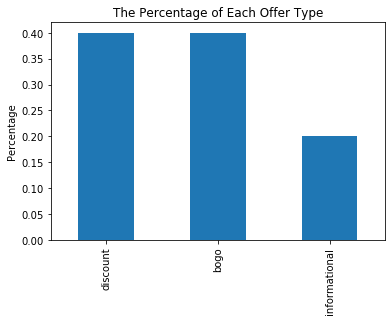

In [16]:
portfolio.offer_type.value_counts(normalize = True).plot(kind = 'bar');
plt.title('The Percentage of Each Offer Type');
plt.ylabel('Percentage'); 

### 2.2.2 profile

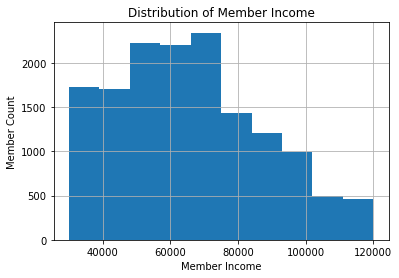

In [17]:
profile.income.hist();
plt.xlabel('Member Income');
plt.ylabel('Member Count');
plt.title('Distribution of Member Income');

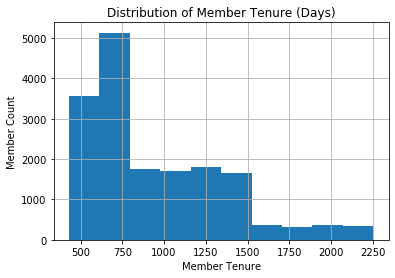

In [18]:
profile.member_tenure.hist();
plt.xlabel('Member Tenure');
plt.ylabel('Member Count');
plt.title('Distribution of Member Tenure (Days)');

### 2.2.3 transcript

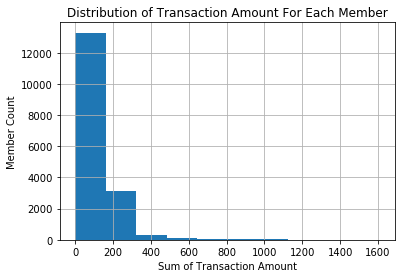

In [19]:
transcript.groupby('id')['amount'].sum().hist();
plt.xlabel('Sum of Transaction Amount');
plt.ylabel('Member Count');
plt.title('Distribution of Transaction Amount For Each Member');

## 2.3. Combine the Data

In [20]:
# calculate the amount the number of transactions for each id
amount = transcript.groupby('id').aggregate({'amount':['sum','count']}).reset_index()
amount.columns = ['id', 'total_transaction_amount', 'number_transactions']

# merge amount with profile
profile = pd.merge(profile, amount, on = 'id')
profile.head()

,age,id,income,member_tenure,gender_F,gender_M,gender_O,total_transaction_amount,number_transactions
0,118,68be06ca386d4c31939f3a4f0e3dd783,NaN,959,0,0,0,20.40,9
1,55,0610b486422d4921ae7d2bf64640c50b,112000.0,806,1,0,0,77.01,3
2,118,38fe809add3b4fcf9315a9694bb96ff5,NaN,444,0,0,0,14.30,6
3,75,78afa995795e4d85b5d9ceeca43f5fef,100000.0,873,1,0,0,159.27,7
4,118,a03223e636434f42ac4c3df47e8bac43,NaN,786,0,0,0,4.65,3


In [21]:
transcript = pd.merge(transcript, portfolio, on = 'event_id')
transcript.head()

,id,event,time,amount,event_id,reward,difficulty,duration,offer_type,web,email,mobile,social
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,1,0
1,ebe7ef46ea6f4963a7dd49f501b26779,offer received,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,1,0
2,f082d80f0aac47a99173ba8ef8fc1909,offer received,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,1,0
3,c0d210398dee4a0895b24444a5fcd1d2,offer received,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,1,0
4,57dd18ec5ddc46828afb81ec5977bef2,offer received,0.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,5,5,7,bogo,1,1,1,0


In [22]:
transcript.offer_type.value_counts()

bogo             71617
discount         69898
informational    26066
Name: offer_type, dtype: int64

In [23]:
def choose_type(offer_type):
    # calculate the target 'percent_response'
    transcript_bogo = transcript[transcript.offer_type == offer_type]
    event_response_count = transcript_bogo.groupby(['id', 'event'])['event_id'].count().unstack()
    event_response_count['percent_viewed'] = event_response_count['offer viewed'] / event_response_count['offer received']
    event_response_count['percent_completed'] = event_response_count['offer completed'] / event_response_count['offer received']
    event_response_count['percent_completed'] = event_response_count['percent_completed'].fillna(0)
    event_response_count['percent_response'] = event_response_count[['percent_viewed', 'percent_completed']].min(axis = 1)
    event_response_count['target'] = event_response_count['percent_response'].apply(lambda x: 1 if x>=0.5 else 0)
    event_response_count = event_response_count.drop(['offer completed', 'offer received', 'offer viewed', 'percent_viewed', 'percent_completed', 'percent_response'], axis =1)
    return event_response_count
event_response_count = choose_type('bogo')

In [24]:
profile = pd.merge(profile, event_response_count, on = 'id')
profile.set_index('id', inplace = True)

# remove duplicates
profile = profile.drop_duplicates()

profile.head()

,age,income,member_tenure,gender_F,gender_M,gender_O,total_transaction_amount,number_transactions,target
id,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,55,112000.0,806,1,0,0,77.01,3,1
38fe809add3b4fcf9315a9694bb96ff5,118,NaN,444,0,0,0,14.30,6,0
78afa995795e4d85b5d9ceeca43f5fef,75,100000.0,873,1,0,0,159.27,7,1
e2127556f4f64592b11af22de27a7932,68,70000.0,521,0,1,0,57.73,3,1
8ec6ce2a7e7949b1bf142def7d0e0586,118,NaN,734,0,0,0,0.00,0,0


# Part 3. Methodology

## 3.1. Data Preprocessing

**Complications/difficulties**: Income is an important feature in the dataset. However, about 12.7% of the members did not provide the income information. I made the decision to imputate the null values with the median, knowing that this is not ideal for the performance. In addition, many members' documented age was 118, which is most likely due to a system error. I replaced 118 by the median age.  

### 3.1.1. Imputation for Null Values

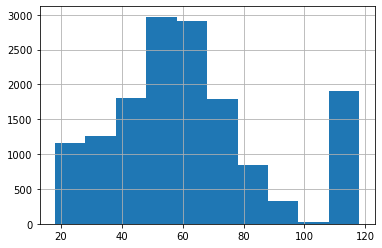

In [25]:
profile['age'].hist();

In [26]:
# replace age 118 by the median age
profile['age'].replace(118, np.nan, inplace = True)
median_age = profile['age'].median(axis = 0)
profile['age'] = profile['age'].fillna(median_age)

In [27]:
print('Percentage of null value in income:', profile.income.isnull().mean())

# replace null value of income by the median 
median_income = profile['income'].median(axis = 0)
profile['income'] = profile['income'].fillna(median_income)

Percentage of null value in income: 0.12699366032699366


### 3.1.2. Normalizing Numerical Features

In [28]:
# Initialize a scaler, then apply it to the features
scaler = MinMaxScaler() 
numerical = ['age', 'income', 'member_tenure', 'total_transaction_amount', 'number_transactions']

profile[numerical] = scaler.fit_transform(profile[numerical])

# Show an example of a record with scaling applied
display(profile.head())

,age,income,member_tenure,gender_F,gender_M,gender_O,total_transaction_amount,number_transactions,target
id,,,,,,,,,
0610b486422d4921ae7d2bf64640c50b,0.445783,0.911111,0.206253,1,0,0,0.047871,0.083333,1
38fe809add3b4fcf9315a9694bb96ff5,0.445783,0.377778,0.007680,0,0,0,0.008889,0.166667,0
78afa995795e4d85b5d9ceeca43f5fef,0.686747,0.777778,0.243006,1,0,0,0.099006,0.194444,1
e2127556f4f64592b11af22de27a7932,0.602410,0.444444,0.049918,0,1,0,0.035886,0.083333,1
8ec6ce2a7e7949b1bf142def7d0e0586,0.445783,0.377778,0.166758,0,0,0,0.000000,0.000000,0


### 3.1.3. Shuffle and Split Data

In [29]:
X = profile.drop('target', axis = 1)
y = profile['target']

# Split the 'features' and 'income' data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, 
                                                    y, 
                                                    test_size = 0.2, 
                                                    random_state = 0)

# Show the results of the split
print("Training set has {} samples.".format(X_train.shape[0]))
print("Testing set has {} samples.".format(X_test.shape[0]))

Training set has 11988 samples.
Testing set has 2997 samples.


## 3.2. Implementation and Refinement

**Complications/difficulties**: There are many Supervised Learning Models to choose from. I listed the reasons why I chose the Logisitic Regression, Random Forest and Ada Boost to test. 

The strength of logistic regression is that it is very efficient, does not require too many computational resources. It is easy to implement, compared to more complex models. The weakness of logistic regression is that it can’t solve non-linear problems since its decision surface is linear. It can sometimes be outperformed by more complex models. logistic regression is not a useful tool unless you have identified all the features. In other words, it is not helpful for feature selection. Since its outcome is discrete, logistic regression can only predict a categorical outcome. The output of logistic regression is 1 and 0, making it a good candidate for this problem. I used logistic regression as a base model, benchmarking more complex models. In addition, it is fast and efficient. 

The strength of Random Forest is that it is versatile, parallelizable, robust to outliers and non-linear data, and great with high dimensionality.  It does not require scaling of the input data. It handles imbalanced data well. It also maintains accuracy even when a large proportion of the data are missing. The main weakness is the complexity. It requires a lot of memory. It is also more difficult to interpret. It tends to overfit. Random Forest is versatile, flexible and relatively fast to train, making it a good candidate for this problem. Its complexity balances out the simplicity of logistic regression. 

The strength of Ada Boost is that it includes few parameters and is easy to implement or tune. It also has implicit feature selection. In cases where outliers and noise have been removed, it is resistant to overfitting. The weakness of Ada Boost is that it is sensitive to noise and outliers. It does not handle imbalanced class well. Ada Boost is a good candidate because of its performance, resistance to overfitting and ease of implementation. 

### 3.2.1. Naive Predictor Performace

The naive predictor is that we predict that everyone has the percent_reponse above or equal to 0.5.

In [30]:
n_records = profile.shape[0]
n_1 = profile[profile.target == 1].shape[0]

In [31]:
# Calculate accuracy, precision and recall
accuracy = n_1 / n_records
recall = 1
precision = n_1 / n_records

# Calculate F-score using the formula above for beta = 0.5 and correct values for precision and recall.
fscore = (1 + 0.5**2)*(recall * precision)/(0.5**2*precision + recall)

# Print the results 
print("Naive Predictor: [Accuracy score: {:.4f}, F-score: {:.4f}]".format(accuracy, fscore))

Naive Predictor: [Accuracy score: 0.5591, F-score: 0.6132]


### 3.2.2. Creating a Training and Predicting Pipeline

In [32]:
def train_predict(learner, sample_size, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    
    results = {}
    
    # Fit the learner to the training data using slicing with 'sample_size' using .fit(training_features[:], training_labels[:])
    start = time() # Get start time
    learner = learner.fit(X_train[:sample_size], y_train[:sample_size])
    end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end -start
        
    # Get the predictions on the test set(X_test),
    # then get predictions on the first 300 training samples(X_train) using .predict()
    start = time() # Get start time
    predictions_test = learner.predict(X_test)
    predictions_train = learner.predict(X_train[:300])
    end = time() # Get end time
    
    # alculate the total prediction time
    results['pred_time'] = end - start
            
    # Compute accuracy on the first 300 training samples which is y_train[:300]
    results['acc_train'] = accuracy_score(y_train[:300], predictions_train)
        
    # Compute accuracy on test set using accuracy_score()
    results['acc_test'] = accuracy_score(y_test, predictions_test)
    
    # Compute F-score on the the first 300 training samples using fbeta_score()
    results['f_train'] = f1_score(y_train[:300], predictions_train)
        
    # Compute F-score on the test set which is y_test
    results['f_test'] = f1_score(y_test, predictions_test)
       
    print("{} trained on {} samples.".format(learner.__class__.__name__, sample_size))
        
    # Return the results
    return results

### 3.2.3. Initial Model Evaluation

In [33]:
# Initialize three models
clf_A = LogisticRegression(random_state = 1, solver = 'liblinear')
clf_B = RandomForestClassifier(random_state = 1, n_estimators = 10)
clf_C = AdaBoostClassifier(random_state = 1)

# Calculate the number of samples for 1%, 10%, and 100% of the training data
samples_100 = len(y_train)
samples_10 = int(samples_100 *0.1)
samples_1 = int(samples_100 *0.01)

# Collect results on the learners
results = {}
for clf in [clf_A, clf_B, clf_C]:
    clf_name = clf.__class__.__name__
    results[clf_name] = {}
    for i, samples in enumerate([samples_1, samples_10, samples_100]):
        results[clf_name][i] = \
        train_predict(clf, samples, X_train, y_train, X_test, y_test)

LogisticRegression trained on 119 samples.
LogisticRegression trained on 1198 samples.
LogisticRegression trained on 11988 samples.
RandomForestClassifier trained on 119 samples.
RandomForestClassifier trained on 1198 samples.
RandomForestClassifier trained on 11988 samples.
AdaBoostClassifier trained on 119 samples.
AdaBoostClassifier trained on 1198 samples.
AdaBoostClassifier trained on 11988 samples.


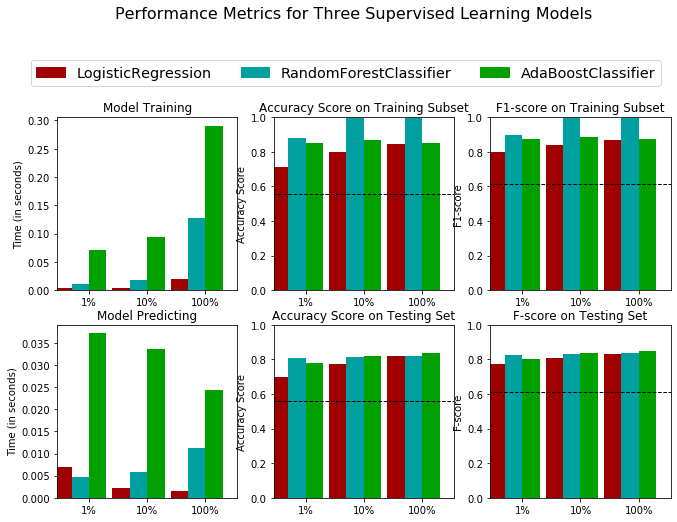

In [34]:
# Run metrics visualization for the three supervised learning models chosen
vs.evaluate(results, accuracy, fscore)

# Part 4. Results

## 4.1. Model Tuning

I used Grid Search to fine tune the hyper parameters. For Random Forest, I chose the following parameters to tune: 'n_estimators', 'min_samples_leaf', 'min_samples_split', and 'max_depth'. These parameters are important because they determine the number of trees in the model, the minimum number of samples required in the leaf node, the minimum number of samples required to split an internal node, and the maximum depth of the tree. 

In [35]:
start = time()
# Initialize the classifier
clf = RandomForestClassifier(random_state = 1, n_estimators = 10)

# Create hyperparameter options
parameters = {'n_estimators': [50, 100, 150],
              'min_samples_leaf': [2, 4, 6], 
              'min_samples_split': [5, 10, 15], 
              'max_depth': [10, 20, 30]}

# Make an fbeta_score scoring object using make_scorer()
scorer = make_scorer(f1_score)

# Perform grid search on the classifier using 'scorer' as the scoring method using GridSearchCV()
grid_obj = GridSearchCV(estimator = clf, param_grid = parameters, scoring = scorer, cv = 3)

# Fit the grid search object to the training data and find the optimal parameters using fit()
grid_fit = grid_obj.fit(X_train, y_train)

# Get the estimator
best_clf = grid_fit.best_estimator_

# Make predictions using the unoptimized and model
predictions = (clf.fit(X_train, y_train)).predict(X_test)
best_predictions = best_clf.predict(X_test)

end = time()

## 4.2. Model Evaluation and Validation
The best parameters identified are as follows: n_estimators=100, min_samples_leaf=4, min_samples_split=5, and max_depth=30. The unoptimized model has the accuracy score of 0.82 and the f1 score of 0.83, while the optimized model has the accuracy score of 0.83 and the f1 score of 0.85. 

In [36]:
# Report the validation results 
print("Unoptimized model\n------")
print("Accuracy score on testing data: {:.4f}".format(accuracy_score(y_test, predictions)))
print("F-score on testing data: {:.4f}".format(f1_score(y_test, predictions)))
print("\nOptimized Model\n------")
print("Final accuracy score on the testing data: {:.4f}".format(accuracy_score(y_test, best_predictions)))
print("Final F-score on the testing data: {:.4f}".format(f1_score(y_test, best_predictions)))
print(f"Time in seconds: {end-start}")

Unoptimized model
------
Accuracy score on testing data: 0.8202
F-score on testing data: 0.8347

Optimized Model
------
Final accuracy score on the testing data: 0.8398
Final F-score on the testing data: 0.8549
Time in seconds: 146.53255915641785


In [37]:
# Report the best model and the paramters
best_clf

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=30, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=4, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=1, verbose=0,
                       warm_start=False)

In [38]:
# Save the model
dump(best_clf, 'best_clf.joblib') 
clf = load('best_clf.joblib') 

## 4.3. Justification

One of the reasons to utilize random forest is its feature_importance method, which helps to understand the variables, and explain the model. Compared to other supervised learners, another advantage of Random Forest is that it is an emseble of decision trees which can be visualized. For business applications, explaining the model and communicating the insights are important. The visualizations of the trees are helpful in the communications. 

### 4.3.1. Feature Importance
The most important features are total transaction amount, income, number of transaction and member tenure, which amount to more than 80% of feature importance. 

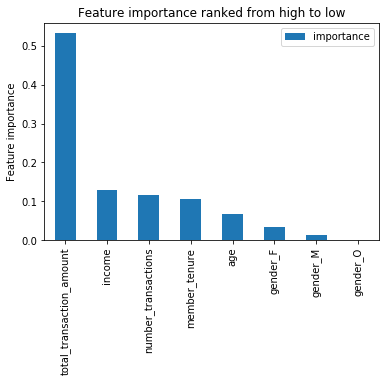

In [39]:
# Calculate feature importances
feature_importances = best_clf.feature_importances_

# Save the results inside a DataFrame using feature_list as an indnex
relative_importances = pd.DataFrame(index=X.columns, data=feature_importances, columns=["importance"])

# Sort values to learn most important features
relative_importances.sort_values(by="importance", ascending=False).plot(kind = 'bar');
plt.title('Feature importance ranked from high to low');
plt.ylabel('Feature importance');

### 4.3.2. Visualize the Decision Tree in Random Forest
The graphs below show how these features are utilized in the decision makings. 

In [40]:
def visualize_tree(n):
    '''
    INPUT:
    n - (int) the n estimator in Random Forest
    OUTPUT:
    The image of the decision tree
    '''
    estimator = best_clf.estimators_[n]
    dot_data = tree.export_graphviz(estimator, out_file=None, feature_names = X.columns, max_depth = 2)
    graph = pydotplus.graph_from_dot_data(dot_data)
    return Image(graph.create_png())

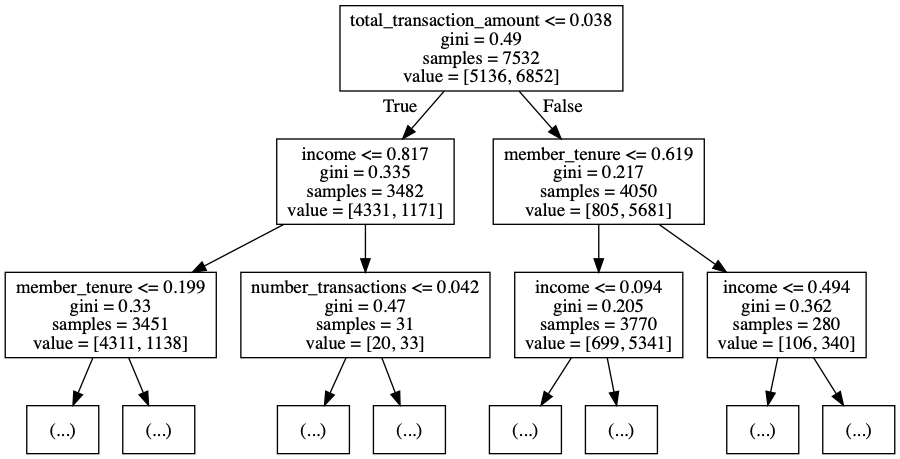

In [41]:
visualize_tree(5)

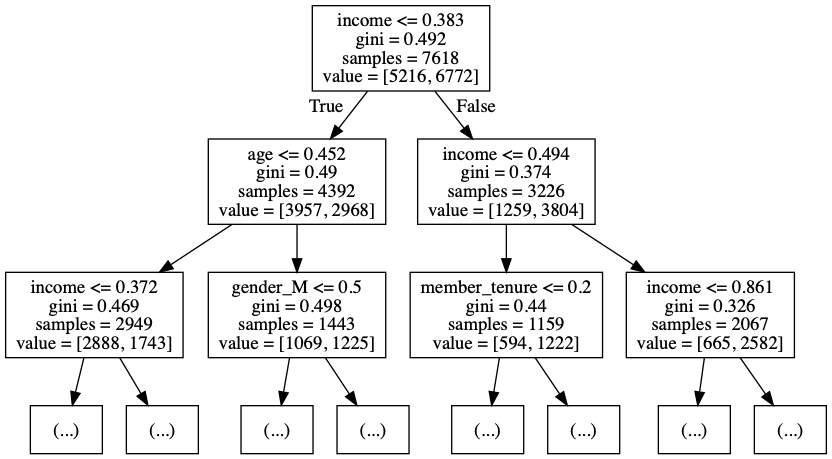

In [42]:
visualize_tree(0)

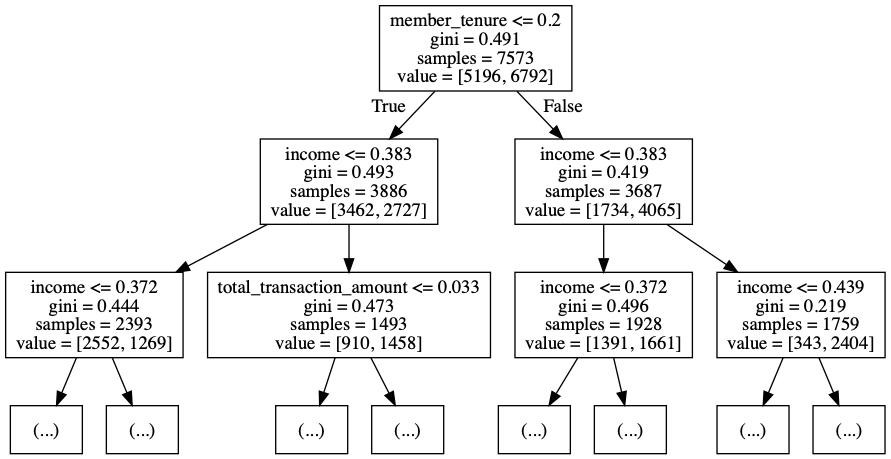

In [43]:
visualize_tree(1)

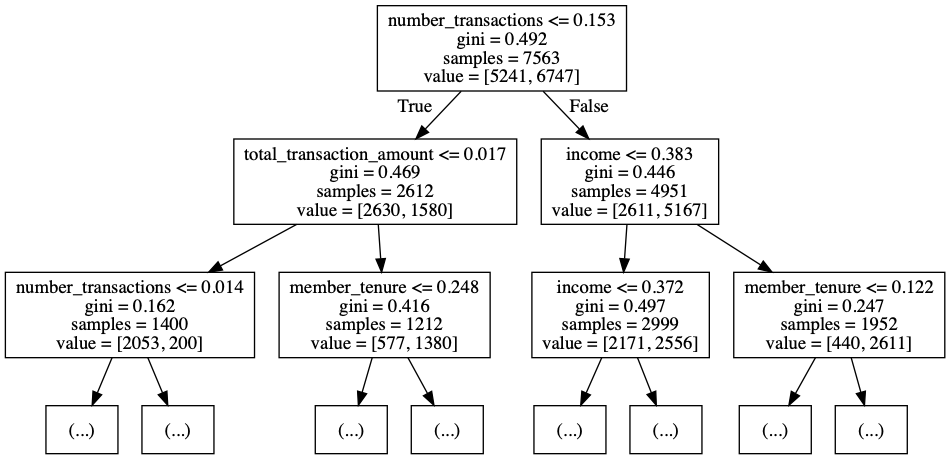

In [44]:
visualize_tree(6)

# Part 5. Conclusion

## 5.1. Reflection

In this project, I first explored, visualized and combined the data. I generated a function choose_type which allows users to choose the offer types (bogo, discount or informational). Then I built several supervised learning models to predict whether to extend that offer type to a customer based on the demographic and transaction data. I used accuracy and f1 scores to evaluate the performance. I also considered the performance of the naive evaluator, which predicted that we should give offers to everyone. I chose Random Forest as the learner because it is a good balance between performance and running time. Lastly, I used grid search to tune the model. The optimized model has the accuracy of 0.83 and the f1 score of 0.85. 

To summarize, I built a model that predicts customers' response to an offer, utilizing Random Forest Classifiers. Specifically, the user of this model could choose an offer type, and identify the customers who are the ideal targets of the offer. 

## 5.2. Improvement

Future imporovement could include recommendations on the communication channels and reward amounts. Currently, the model only provides predictions on the customers who are more likely to respond to an offer type. The next step would be to identify the ideal channels to communicate the offers. In addition, regression models could be implemented to identify the optimal reward amounts. 